# Fantasy Premier League Project 

# ROLLING STATISTICS WITH DEFENDERS ONLY

### Libraries 

In [1]:
import glob
import pandas as pd
import seaborn as sns
import numpy as np
import category_encoders as ce
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# extract Features and target variables
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

# Machine Learning Library
from sklearn.preprocessing import LabelEncoder # Encode Categorical Variable to Numerical Variable
from sklearn.impute import SimpleImputer # Imputer Class to replace missing values
from sklearn.metrics import confusion_matrix # Library for model evaluation
from sklearn.model_selection import train_test_split # Library to split datset into test and train

from sklearn.linear_model  import LogisticRegression # Logistic Regression Classifier
from sklearn.linear_model import SGDClassifier # Stochastic Gradient Descent Classifier
from sklearn.tree import DecisionTreeClassifier # Decision Tree Classifier
from sklearn.ensemble  import RandomForestClassifier # Random Forest Classifier
from sklearn.neighbors import KNeighborsClassifier # K Nearest neighbors Classifier
from sklearn.naive_bayes import GaussianNB #Naive Bayes Classifier
from sklearn.svm import SVC #Support vector Machine Classifier
from sklearn.ensemble import AdaBoostClassifier # Ada Boost Classifier
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score

### File reading

In [2]:
#list all csv files

fpl_files_23 = glob.glob('gw*_1.{}'.format('csv')) #fpl 2022-23 files

In [3]:
fpl_23= pd.concat([pd.read_csv(f) for f in fpl_files_23 ], ignore_index=True)
fpl_23.head()

C:\Users\Joseph\AppData\Local\Temp\ipykernel_22536\180186912.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  fpl_23= pd.concat([pd.read_csv(f) for f in fpl_files_23 ], ignore_index=True)


,name,position,team,xP,assists,bonus,bps,clean_sheets,creativity,element,...,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards
0,Nathan Redmond,MID,Southampton,0.0,0,0,0,0,0.0,403,...,0,4,0.0,0,-312,0,312,53,False,0
1,Junior Stanislas,MID,Bournemouth,-0.1,0,0,0,0,0.0,58,...,1,2,0.0,0,-159,90,249,48,True,0
2,Armando Broja,FWD,Chelsea,3.5,0,0,27,0,0.3,150,...,0,3,17.0,5,-2457,2715,5172,53,True,0
3,Fabian Schär,DEF,Newcastle,3.3,0,0,10,0,0.5,366,...,1,5,2.0,2,121324,161290,39966,48,True,0
4,Jonny Evans,DEF,Leicester,2.5,0,0,15,0,1.5,249,...,1,2,33.0,1,2549,3862,1313,44,False,0


## PREPROCESSING

In [4]:
fpl_23 = fpl_23[fpl_23['position']=='DEF']

In [5]:
fpl_23.dtypes.head()
#We see that many features have tthe incorect data type (object). 

name         object
position     object
team         object
xP          float64
assists      object
dtype: object

In [6]:
#We transform all the strings which represent numeric values, to floats.

fpl_23[['value','total_points','assists','bonus','bps','clean_sheets','element','minutes','goals_conceded','goals_scored','own_goals','penalties_missed','penalties_saved','red_cards','saves','selected','starts','team_a_score','team_h_score','transfers_balance','transfers_in','transfers_out',"yellow_cards"]]=fpl_23[['value','total_points','assists','bonus','bps','clean_sheets','element','minutes','goals_conceded','goals_scored','own_goals','penalties_missed','penalties_saved','red_cards','saves','selected','starts','team_a_score','team_h_score','transfers_balance','transfers_in','transfers_out',"yellow_cards"]].astype(float)
fpl_23

,name,position,team,xP,assists,bonus,bps,clean_sheets,creativity,element,...,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards
3,Fabian Schär,DEF,Newcastle,3.3,0.0,0.0,10.0,0.0,0.5,366.0,...,1.0,5.0,2.0,2.0,121324.0,161290.0,39966.0,48.0,True,0.0
4,Jonny Evans,DEF,Leicester,2.5,0.0,0.0,15.0,0.0,1.5,249.0,...,1.0,2.0,33.0,1.0,2549.0,3862.0,1313.0,44.0,False,0.0
9,Fin Stevens,DEF,Brentford,0.0,0.0,0.0,0.0,0.0,0.0,540.0,...,1.0,5.0,0.0,0.0,-1217.0,0.0,1217.0,40.0,False,0.0
12,Wesley Fofana,DEF,Chelsea,0.0,0.0,0.0,0.0,0.0,0.0,272.0,...,0.0,3.0,0.0,0.0,-35962.0,25584.0,61546.0,44.0,True,0.0
18,Nathaniel Phillips,DEF,Liverpool,0.5,0.0,0.0,0.0,0.0,0.0,501.0,...,2.0,3.0,0.0,0.0,-480.0,1728.0,2208.0,40.0,False,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26491,Ethan Pinnock,DEF,Brentford,0.4,0.0,0.0,0.0,0.0,0.0,92.0,...,0.0,0.0,0.0,0.0,-39.0,24.0,63.0,44.0,False,0.0
26496,James Justin,DEF,Leicester,3.2,0.0,0.0,21.0,1.0,1.3,268.0,...,0.0,4.0,8.0,6.0,31189.0,47561.0,16372.0,43.0,True,0.0
26497,Çaglar Söyüncü,DEF,Leicester,0.5,0.0,0.0,0.0,0.0,0.0,267.0,...,0.0,4.0,0.0,0.0,-844.0,957.0,1801.0,42.0,True,0.0
26501,Ryan Sessegnon,DEF,Spurs,1.0,0.0,0.0,3.0,0.0,0.2,436.0,...,1.0,3.0,0.0,1.0,-6915.0,4177.0,11092.0,45.0,False,0.0


In [7]:
fpl_23.dtypes.head()

name         object
position     object
team         object
xP          float64
assists     float64
dtype: object

### Exploratory data analysis

In [8]:
fpl_23.describe()
#Short summary for descriptive statistics.

,xP,assists,bonus,bps,clean_sheets,creativity,element,expected_assists,expected_goal_involvements,expected_goals,...,starts,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,yellow_cards
count,9183.000000,9183.000000,9183.00000,9183.000000,9183.000000,9183.000000,9183.000000,9183.000000,9183.000000,9183.000000,...,9183.000000,9183.000000,9183.000000,9183.000000,9183.000000,9.183000e+03,9.183000e+03,9.183000e+03,9183.000000,9183.000000
mean,1.116204,0.019601,0.07895,5.826309,0.091800,2.881008,349.293913,0.012065,0.022559,0.011867,...,0.216705,1.217576,1.636393,2.078624,1.082762,1.681873e+03,1.395945e+04,1.227758e+04,44.567897,0.058913
std,1.901332,0.144028,0.40253,9.032794,0.288759,8.045769,194.380805,0.054967,0.085090,0.059523,...,0.412022,1.183146,1.409698,6.258718,2.246881,6.151077e+04,5.417158e+04,4.770075e+04,5.315543,0.235475
min,-3.000000,0.000000,0.00000,-9.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-4.000000,-1.427216e+06,0.000000e+00,0.000000e+00,37.000000,0.000000
25%,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,194.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,-1.165500e+03,3.800000e+01,1.290000e+02,40.000000,0.000000
50%,0.100000,0.000000,0.00000,0.000000,0.000000,0.000000,351.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,0.000000,0.000000,-6.200000e+01,3.720000e+02,9.980000e+02,44.000000,0.000000
75%,1.800000,0.000000,0.00000,11.000000,0.000000,0.800000,504.000000,0.000000,0.000000,0.000000,...,0.000000,2.000000,2.000000,0.000000,1.000000,9.100000e+01,4.178000e+03,6.692000e+03,45.000000,0.000000
max,14.000000,2.000000,3.00000,58.000000,1.000000,124.000000,775.000000,1.130000,1.190000,1.180000,...,1.000000,6.000000,9.000000,85.000000,18.000000,1.047059e+06,1.219571e+06,1.445499e+06,78.000000,1.000000


In [9]:
fpl_23["total_points"].mean()

1.0827616247413698

In [10]:
#find the top defenders by mean
fpl_23.groupby("name")["total_points"].agg(["max","min","mean","median"]).sort_values(by="mean",ascending=False).head()

,max,min,mean,median
name,,,,
Kieran Trippier,12.0,0.0,5.210526,5.5
Benjamin White,8.0,0.0,4.105263,5.0
Trent Alexander-Arnold,17.0,0.0,4.105263,2.5
Gabriel dos Santos Magalhães,15.0,0.0,3.842105,2.0
Ben Mee,14.0,0.0,3.763158,2.0


## Checking for missing or NA values.

#### We check our data frame for both missing or NA values

In [11]:
missing_val=fpl_23.isnull().sum()
missing_val[0:]

name                          0
position                      0
team                          0
xP                            0
assists                       0
bonus                         0
bps                           0
clean_sheets                  0
creativity                    0
element                       0
expected_assists              0
expected_goal_involvements    0
expected_goals                0
expected_goals_conceded       0
fixture                       0
goals_conceded                0
goals_scored                  0
ict_index                     0
influence                     0
kickoff_time                  0
minutes                       0
opponent_team                 0
own_goals                     0
penalties_missed              0
penalties_saved               0
red_cards                     0
round                         0
saves                         0
selected                      0
starts                        0
team_a_score                  0
team_h_s

In [12]:
na_val=fpl_23.isna().sum()
na_val[0:]

name                          0
position                      0
team                          0
xP                            0
assists                       0
bonus                         0
bps                           0
clean_sheets                  0
creativity                    0
element                       0
expected_assists              0
expected_goal_involvements    0
expected_goals                0
expected_goals_conceded       0
fixture                       0
goals_conceded                0
goals_scored                  0
ict_index                     0
influence                     0
kickoff_time                  0
minutes                       0
opponent_team                 0
own_goals                     0
penalties_missed              0
penalties_saved               0
red_cards                     0
round                         0
saves                         0
selected                      0
starts                        0
team_a_score                  0
team_h_s

In [13]:
# First, group by 'name' and 'round' and then take the mean of the matches for players with more than one match in a gameweek
fpl_23 = fpl_23.groupby(['name', 'round']).mean(numeric_only = True).reset_index()

# Now, you can set the index to the aggregated DataFrame
fpl_23.set_index(['name', 'round'], inplace=True)

# And sort the DataFrame by 'name' and 'round' again
fpl_23 = fpl_23.sort_values(by=['name', 'round'])

In [14]:
fpl_23.index.value_counts()

name             round
Aaron Cresswell  1        1
Nathan Collins   26       1
Nathan Ferguson  2        1
                 1        1
Nathan Collins   38       1
                         ..
Jan Bednarek     16       1
                 15       1
                 14       1
                 13       1
Çaglar Söyüncü   38       1
Name: count, Length: 8621, dtype: int64

In [15]:
fpl_23

xP  assists  bonus   bps  clean_sheets  creativity  \
name            round                                                        
Aaron Cresswell 1      1.3      0.0    0.0  16.0           0.0        18.7   
                2      2.0      0.0    0.0  14.0           0.0        65.8   
                3      1.0      0.0    0.0   6.0           0.0        38.8   
                4      2.2      0.0    0.0  26.0           1.0         5.8   
                5      1.7      0.0    0.0  16.0           0.0         1.5   
...                    ...      ...    ...   ...           ...         ...   
Çaglar Söyüncü  34     2.8      0.0    3.0  30.0           0.0         0.4   
                35     2.8      0.0    0.0  12.0           0.0         0.8   
                36     0.0      0.0    0.0   0.0           0.0         0.0   
                37     0.0      0.0    0.0   0.0           0.0         0.0   
                38     0.0      0.0    0.0   0.0           0.0         0.0   

                       element  expected_assists  expected_goal_involvements  \
name            round                                                          
Aaron Cresswell 1        457.0              0.00                        0.00   
                2        457.0              0.00                        0.00   
                3        457.0              0.00                        0.00   
                4        457.0              0.00                        0.00   
                5        457.0              0.00                        0.00   
...                        ...               ...                         ...   
Çaglar Söyüncü  34       267.0              0.01                        0.11   
                35       267.0              0.00                        0.00   
                36       267.0              0.00                        0.00   
                37       267.0              0.00                        0.00   
                38       267.0              0.00                        0.00   

                       expected_goals  ...  starts  team_a_score  \
name            round                  ...                         
Aaron Cresswell 1                 0.0  ...     0.0           2.0   
                2                 0.0  ...     0.0           0.0   
                3                 0.0  ...     0.0           2.0   
                4                 0.0  ...     0.0           1.0   
                5                 0.0  ...     0.0           1.0   
...                               ...  ...     ...           ...   
Çaglar Söyüncü  34                0.1  ...     1.0           2.0   
                35                0.0  ...     1.0           3.0   
                36                0.0  ...     0.0           3.0   
                37                0.0  ...     0.0           0.0   
                38                0.0  ...     0.0           1.0   

                       team_h_score  threat  total_points  transfers_balance  \
name            round                                                          
Aaron Cresswell 1               0.0     0.0           1.0                0.0   
                2               1.0     1.0           2.0            21509.0   
                3               0.0    18.0           0.0           -19414.0   
                4               0.0     8.0           6.0           -53162.0   
                5               1.0     0.0           2.0           -21500.0   
...                             ...     ...           ...                ...   
Çaglar Söyüncü  34              2.0    17.0          10.0              -27.0   
                35              5.0     0.0           0.0             3021.0   
                36              0.0     0.0           0.0             -340.0   
                37              0.0     0.0           0.0            -1220.0   
                38              2.0     0.0           0.0             -672.0   

                       transfers_in  trans

In [16]:
fpl_23.columns

Index(['xP', 'assists', 'bonus', 'bps', 'clean_sheets', 'creativity',
       'element', 'expected_assists', 'expected_goal_involvements',
       'expected_goals', 'expected_goals_conceded', 'goals_conceded',
       'goals_scored', 'ict_index', 'influence', 'minutes', 'own_goals',
       'penalties_missed', 'penalties_saved', 'red_cards', 'saves', 'selected',
       'starts', 'team_a_score', 'team_h_score', 'threat', 'total_points',
       'transfers_balance', 'transfers_in', 'transfers_out', 'value',
       'yellow_cards'],
      dtype='object')

In [17]:
def rolling_average(series, window):
    return series.rolling(min_periods=1, window=window).mean().shift(1)

def get_player_averages(df, stats):
    feature_names = []
    for stat in stats + ['total_points']:
        # Make sure the stat is a column in the dataframe
        if stat in df.columns:
            grouped = df.groupby('name')[stat]  # Group by name
            df['season_{}'.format(stat)] = grouped.transform(lambda x: rolling_average(x, 16))
            df['recent_{}'.format(stat)] = grouped.transform(lambda x: rolling_average(x, 4))
            df['prev_{}'.format(stat)] = grouped.transform(lambda x: rolling_average(x, 1))
            feature_names += [time + "_" + stat for time in ['season', 'recent', 'prev']]
        else:
            raise KeyError(f"The stat '{stat}' was not found in the dataframe.")
    return df, feature_names

# Example usage
stats = ['xP', 'assists', 'bonus', 'bps', 'clean_sheets', 'creativity',
       'element', 'expected_assists', 'expected_goal_involvements',
       'expected_goals', 'expected_goals_conceded', 'goals_conceded',
       'goals_scored', 'ict_index', 'influence', 'minutes', 'own_goals',
       'penalties_missed', 'penalties_saved', 'red_cards', 'saves', 'selected',
       'starts', 'team_a_score', 'team_h_score', 'threat', 'total_points',
       'transfers_balance', 'transfers_in', 'transfers_out', 'value',
       'yellow_cards']

get_player_averages(fpl_23, stats)
fpl_23[['season_total_points', 'recent_total_points', 'prev_total_points', 'total_points']]

season_total_points  recent_total_points  \
name            round                                             
Aaron Cresswell 1                      NaN                  NaN   
                2                    1.000                 1.00   
                3                    1.500                 1.50   
                4                    1.000                 1.00   
                5                    2.250                 2.25   
...                                    ...                  ...   
Çaglar Söyüncü  34                   0.250                 1.00   
                35                   0.875                 3.50   
                36                   0.875                 3.50   
                37                   0.875                 3.00   
                38                   0.875                 2.50   

                       prev_total_points  total_points  
name            round                                   
Aaron Cresswell 1                    NaN           1.0  
                2                    1.0           2.0  
                3                    2.0           0.0  
                4                    0.0           6.0  
                5                    6.0           2.0  
...                                  ...           ...  
Çaglar Söyüncü  34                   2.0          10.0  
                35                  10.0           0.0  
                36                   0.0           0.0  
                37                   0.0           0.0  
                38                   0.0           0.0  

[8621 rows x 4 columns]

In [18]:
fpl_23

xP  assists  bonus   bps  clean_sheets  creativity  \
name            round                                                        
Aaron Cresswell 1      1.3      0.0    0.0  16.0           0.0        18.7   
                2      2.0      0.0    0.0  14.0           0.0        65.8   
                3      1.0      0.0    0.0   6.0           0.0        38.8   
                4      2.2      0.0    0.0  26.0           1.0         5.8   
                5      1.7      0.0    0.0  16.0           0.0         1.5   
...                    ...      ...    ...   ...           ...         ...   
Çaglar Söyüncü  34     2.8      0.0    3.0  30.0           0.0         0.4   
                35     2.8      0.0    0.0  12.0           0.0         0.8   
                36     0.0      0.0    0.0   0.0           0.0         0.0   
                37     0.0      0.0    0.0   0.0           0.0         0.0   
                38     0.0      0.0    0.0   0.0           0.0         0.0   

                       element  expected_assists  expected_goal_involvements  \
name            round                                                          
Aaron Cresswell 1        457.0              0.00                        0.00   
                2        457.0              0.00                        0.00   
                3        457.0              0.00                        0.00   
                4        457.0              0.00                        0.00   
                5        457.0              0.00                        0.00   
...                        ...               ...                         ...   
Çaglar Söyüncü  34       267.0              0.01                        0.11   
                35       267.0              0.00                        0.00   
                36       267.0              0.00                        0.00   
                37       267.0              0.00                        0.00   
                38       267.0              0.00                        0.00   

                       expected_goals  ...  prev_transfers_in  \
name            round                  ...                      
Aaron Cresswell 1                 0.0  ...                NaN   
                2                 0.0  ...                0.0   
                3                 0.0  ...            45044.0   
                4                 0.0  ...            20572.0   
                5                 0.0  ...             5437.0   
...                               ...  ...                ...   
Çaglar Söyüncü  34                0.1  ...              563.0   
                35                0.0  ...              339.0   
                36                0.0  ...             3328.0   
                37                0.0  ...              518.0   
                38                0.0  ...              162.0   

                       season_transfers_out  recent_transfers_out  \
name            round                                               
Aaron Cresswell 1                       NaN                   NaN   
                2                  0.000000              0.000000   
                3              11767.500000          11767.500000   
                4              21173.666667          21173.666667   
                5              30530.000000          30530.000000   
...                                     ...                   ...   
Çaglar Söyüncü  34               290.062500            150.250000   
                35               284.812500            201.000000   
                36               279.812500            238.250000   
                37               296.875000            418.500000   
                38               358.625000            728.250000   

                       prev_transfers_out  season_value  recent_value  \
name            round                                                   
Aaron Cresswell 1                     NaN           NaN           NaN   
     

In [19]:
fpl_23.columns.size

128

## Boxplots for checking outliers for our target value (next gameweek points)

C:\Users\Joseph\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


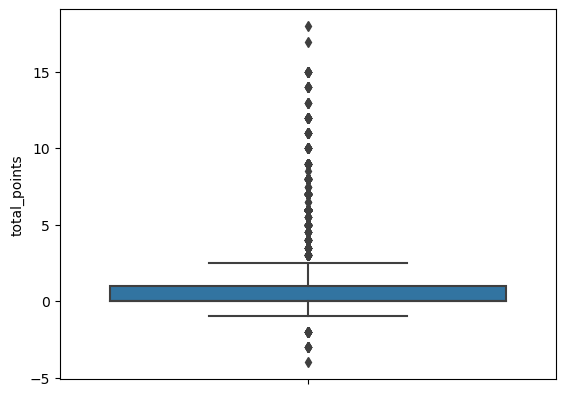

In [20]:
fig, ax = plt.subplots()
sns.boxplot(data=fpl_23, y='total_points')
ax.set_ylabel('total_points')
plt.show()

We see from the boxplot that we have too many outliers.
This is likely happens because we take into account all the players in the premier league, even the ones that have little play time.
__These players have few to none points dragging down the mean, making the other regular players look like outliers.__

In [21]:
fpl_23.reset_index(inplace=True)

In [22]:
fpl_23.head()

,name,round,xP,assists,bonus,bps,clean_sheets,creativity,element,expected_assists,...,prev_transfers_in,season_transfers_out,recent_transfers_out,prev_transfers_out,season_value,recent_value,prev_value,season_yellow_cards,recent_yellow_cards,prev_yellow_cards
0,Aaron Cresswell,1,1.3,0.0,0.0,16.0,0.0,18.7,457.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Aaron Cresswell,2,2.0,0.0,0.0,14.0,0.0,65.8,457.0,0.0,...,0.0,0.000000,0.000000,0.0,50.0,50.0,50.0,0.000000,0.000000,0.0
2,Aaron Cresswell,3,1.0,0.0,0.0,6.0,0.0,38.8,457.0,0.0,...,45044.0,11767.500000,11767.500000,23535.0,50.0,50.0,50.0,0.000000,0.000000,0.0
3,Aaron Cresswell,4,2.2,0.0,0.0,26.0,1.0,5.8,457.0,0.0,...,20572.0,21173.666667,21173.666667,39986.0,50.0,50.0,50.0,0.333333,0.333333,1.0
4,Aaron Cresswell,5,1.7,0.0,0.0,16.0,0.0,1.5,457.0,0.0,...,5437.0,30530.000000,30530.000000,58599.0,50.0,50.0,50.0,0.250000,0.250000,0.0


### Since we dont care much about any players with barely any game time we tried removing them.

In [23]:
# Calculate the mean of column 'minutes' for each player
player_means = fpl_23.groupby('name')['minutes'].mean()

# Filter for players with mean minutes equal to 0
players_with_mean_zero = player_means[player_means ==0]

# Remove players with mean minutes equal to 0 from the original DataFrame
fpl_23 = fpl_23[~fpl_23['name'].isin(players_with_mean_zero.index)]

C:\Users\Joseph\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


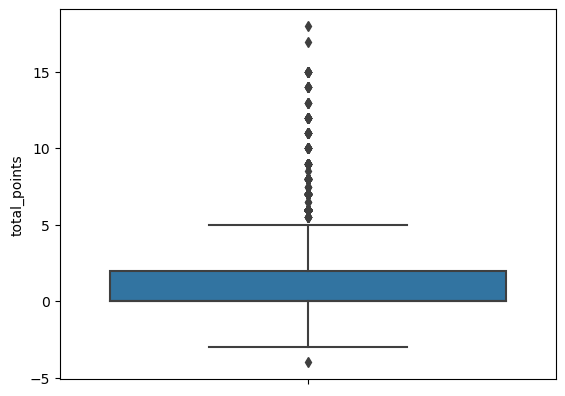

In [24]:
fig, ax = plt.subplots()
sns.boxplot(data=fpl_23, y='total_points')
ax.set_ylabel('total_points')
plt.show()


#### We can see that we still have too many outliers. So we considered taking into consideration only the players which have more playtime.

In [25]:
# We repeat the same process as before
player_means = fpl_23.groupby('name')['minutes'].mean()

# Filter for players with mean minutes fewer than 30
players_with_mean_zero = player_means[player_means <30]

# Remove players with mean minutes fewer than 30 from the original DataFrame
fpl_23 = fpl_23[~fpl_23['name'].isin(players_with_mean_zero.index)]

C:\Users\Joseph\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


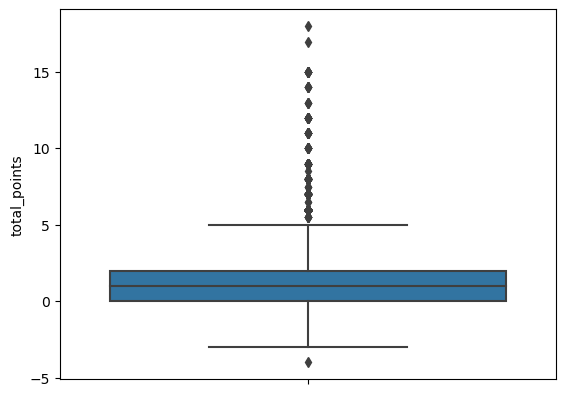

In [26]:
fig, ax = plt.subplots()
sns.boxplot(data=fpl_23, y='total_points')
ax.set_ylabel('total_points')
plt.show()

In [27]:
# We repeat the same process as before
player_means = fpl_23.groupby('name')['minutes'].mean()

# Filter for players with mean minutes fewer than 45
players_with_mean_zero = player_means[player_means <45]

# Remove players with mean minutes fewer than 45 from the original DataFrame
fpl_23 = fpl_23[~fpl_23['name'].isin(players_with_mean_zero.index)]

C:\Users\Joseph\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


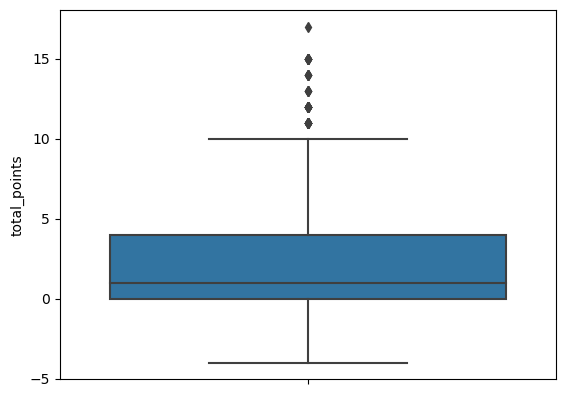

In [28]:
fig, ax = plt.subplots()
sns.boxplot(data=fpl_23, y='total_points')
ax.set_ylabel('total_points')
plt.show()

In [29]:
# We repeat the same process as before
player_means = fpl_23.groupby('name')['minutes'].mean()

# Filter for players with mean minutes fewer than 60
players_with_mean_zero = player_means[player_means <60]

# Remove players with mean minutes fewer than 60 from the original DataFrame
fpl_23 = fpl_23[~fpl_23['name'].isin(players_with_mean_zero.index)]

C:\Users\Joseph\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


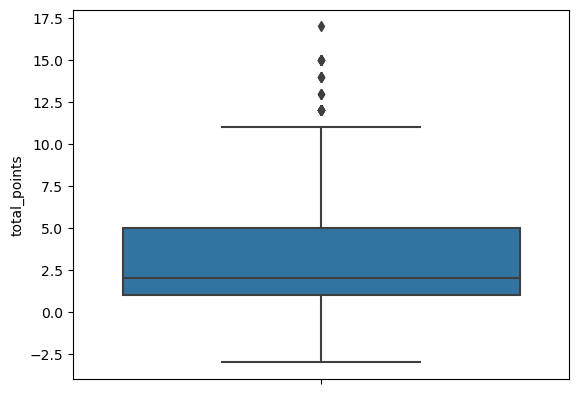

In [30]:
fig, ax = plt.subplots()
sns.boxplot(data=fpl_23, y='total_points')
ax.set_ylabel('total_points')
plt.show()

### We decided that we will not include any players with a mean value less than 60 minutes of playtime.
This way we focus on the players which are usually in the starting lineup, which are also more likely to score more points, making them a better choice for the Fantasy Team.

#### Interquaretile Range Method (IQR)

In [31]:
Q1 = fpl_23['total_points'].quantile(0.25)
Q3 = fpl_23['total_points'].quantile(0.75)
IQR = Q3-Q1
upper_whisker = min(Q3 + 1.5*IQR, max(fpl_23['total_points']))
lower_whisker = max(Q1 - 1.5*IQR, min(fpl_23['total_points']))
print("The Upper whisker is {} and the Lower whisker is {}.".format(upper_whisker,lower_whisker))

The Upper whisker is 11.0 and the Lower whisker is -3.0.


### Data Visualizations.

C:\Users\Joseph\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0, 0.5, 'total_points')

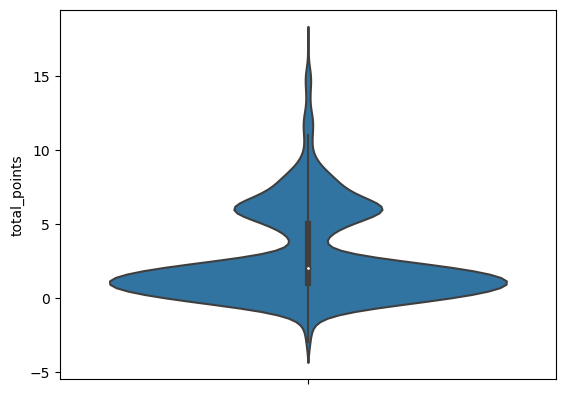

In [32]:
#Violin plot
fig, ax = plt.subplots()
sns.violinplot(data=fpl_23, y='total_points')
ax.set_ylabel('total_points')

C:\Users\Joseph\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Joseph\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 0, 'total_points')

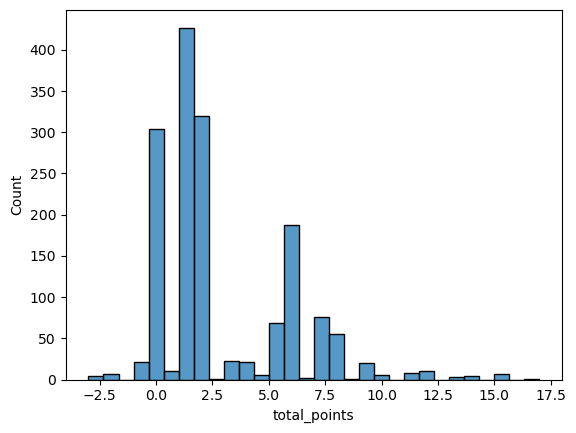

In [33]:
plt.figure()
sns.histplot(fpl_23, x='total_points')
plt.xlabel('total_points')

### Here we use Ordinal enconding on the team.
#### We do this so we can include the fixture difficulty of the speciffic match.


### One hot encoding for the column next_gameweek_home_away

In [34]:
fpl_23.columns

Index(['name', 'round', 'xP', 'assists', 'bonus', 'bps', 'clean_sheets',
       'creativity', 'element', 'expected_assists',
       ...
       'prev_transfers_in', 'season_transfers_out', 'recent_transfers_out',
       'prev_transfers_out', 'season_value', 'recent_value', 'prev_value',
       'season_yellow_cards', 'recent_yellow_cards', 'prev_yellow_cards'],
      dtype='object', length=130)

### This is our 4 datasets: 
- Dataset with outliers
- Dataset without outliers
- Scaled Dataset with outliers
- Scaled Dataset without outliers

In [35]:
fpl_23.drop(columns = ['xP', 'assists', 'bonus', 'bps', 'clean_sheets',
       'creativity', 'element', 'expected_assists',
       'expected_goal_involvements', 'expected_goals',
       'expected_goals_conceded', 'goals_conceded', 'goals_scored',
       'ict_index', 'influence', 'minutes', 'own_goals', 'penalties_missed',
       'penalties_saved', 'red_cards', 'saves', 'selected', 'starts',
       'team_a_score', 'team_h_score', 'threat',
       'transfers_balance', 'transfers_in', 'transfers_out', 'value',
       'yellow_cards'], inplace=True, axis=1)

In [36]:
fpl_23.fillna(0,inplace=True)

In [37]:
fpl_23.isna().sum()

name                   0
round                  0
total_points           0
season_xP              0
recent_xP              0
                      ..
recent_value           0
prev_value             0
season_yellow_cards    0
recent_yellow_cards    0
prev_yellow_cards      0
Length: 99, dtype: int64

In [38]:
#Dataset without outliers
fpl_23_no_outl = fpl_23[ (fpl_23['total_points'] >= lower_whisker) & (fpl_23['total_points'] <= upper_whisker) ]

# Scaled dataset with outliers
fpl_23_scaled = fpl_23.select_dtypes(include=['number'])
fpl_23_scaled = fpl_23_scaled.drop(['total_points'], axis=1)
rscaler = RobustScaler()

robustRescaledX = rscaler.fit_transform(fpl_23_scaled)
fpl_23_scaled = pd.DataFrame(robustRescaledX, columns=fpl_23_scaled.columns)
cols_to_add = ['total_points']

for col in cols_to_add:
    fpl_23_scaled[col] = fpl_23[col].reset_index(drop=True)


# Scaled dataset without outliers
fpl_23_scaled_no_outl = fpl_23_no_outl.select_dtypes(include=['number'])
fpl_23_scaled_no_outl = fpl_23_scaled_no_outl.drop(['total_points'], axis=1)
rscaler2 = RobustScaler()

robustRescaledX2 = rscaler2.fit_transform(fpl_23_scaled_no_outl)
fpl_23_scaled_no_outl = pd.DataFrame(robustRescaledX2, columns=fpl_23_scaled_no_outl.columns)
cols_to_add = ['total_points']

for col in cols_to_add:
    fpl_23_scaled_no_outl[col] = fpl_23_no_outl[col].reset_index(drop=True)

In [39]:
x=fpl_23.select_dtypes(include=['number'])
x=x.drop(columns=['total_points'])
y=fpl_23['total_points']

In [40]:
x_no_outl=fpl_23_no_outl.select_dtypes(include=['number'])
x_no_outl=x_no_outl.drop(columns=['total_points'])
y_no_outl=fpl_23_no_outl['total_points']

In [41]:
x_scaled=fpl_23_scaled.select_dtypes(include=['number'])
x_scaled=x_scaled.drop(columns=['total_points'])
# we use the y for our target value here

In [42]:
x_scaled_no_outl=fpl_23_scaled_no_outl.select_dtypes(include=['number'])
x_scaled_no_outl=x_scaled_no_outl.drop(columns=['total_points'])
# we use the y_no_outl for our target value here

In [43]:
y.value_counts().sort_index(ascending=True)

total_points
-3.0       4
-2.0       7
-1.0      20
-0.5       1
 0.0     304
 0.5      11
 1.0     414
 1.5      13
 2.0     320
 2.5       1
 3.0      19
 3.5       4
 4.0      21
 4.5       6
 5.0      64
 5.5       5
 6.0     187
 6.5       2
 7.0      75
 7.5       1
 8.0      55
 8.5       1
 9.0      20
 10.0      6
 11.0      8
 12.0     11
 13.0      3
 14.0      4
 15.0      7
 17.0      1
Name: count, dtype: int64

#### Classification
Class 1: below or equal 0 points   
Class 2: 1 points    
Class 3: 2 points  
Class 4: from 3 to 6 points  
Class 5: from 7 to 9 points  
Class 6: from 10 points and above

In [44]:
# new Y for classification for the dataset with outliers
ycl = pd.cut(y, bins = [-np.inf, 0, 1, 2, 6, 9, np.inf], labels =['Class 1','Class 2','Class 3','Class 4','Class 5','Class 6'])
ycl.value_counts()

total_points
Class 2    425
Class 1    336
Class 3    333
Class 4    307
Class 5    154
Class 6     40
Name: count, dtype: int64

In [45]:
# new Y for classification for the dataset without outliers
y_no_outl_cl = pd.cut(y_no_outl, bins = [-np.inf, 0, 1, 2, 6, 9, np.inf], labels =['Class 1','Class 2','Class 3','Class 4','Class 5','Class 6'])
y_no_outl_cl.value_counts()

total_points
Class 2    425
Class 1    336
Class 3    333
Class 4    307
Class 5    154
Class 6     14
Name: count, dtype: int64

#### Correlation matrix - Heatmap

<Figure size 640x480 with 0 Axes>

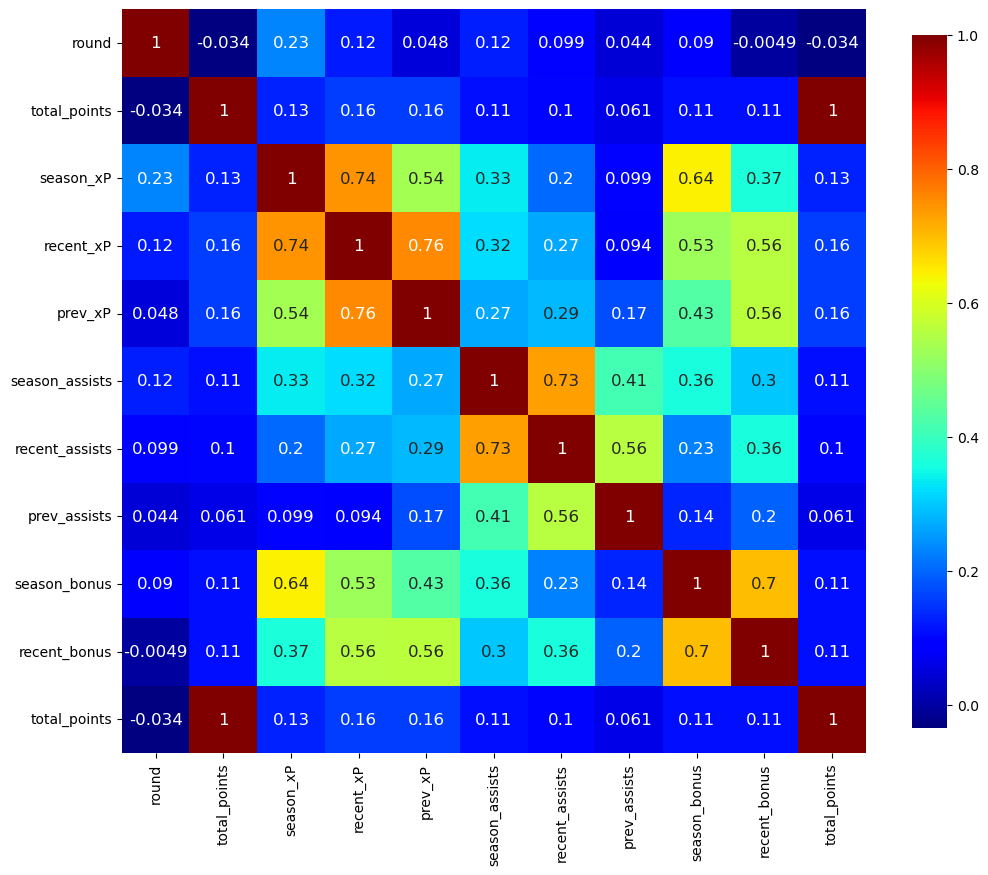

In [46]:
numeric_fpl_23 = fpl_23.select_dtypes(include=['number'])
coln=numeric_fpl_23.columns.get_loc('total_points')

cols_to_select = list(range(0,10)) + [coln] 
f15=numeric_fpl_23.iloc[:,cols_to_select]
from matplotlib import cm as cm

plt.figure()

corr = f15.corr(method='pearson')
cmap = plt.colormaps['jet']
#cmap = cm.get_cmap('jet', 30)
_, ax = plt.subplots( figsize = ( 12 , 10 ) )
sns.heatmap(corr, cmap = cmap,  square=True, cbar_kws={ 'shrink' : .9 }, ax=ax, annot = True, annot_kws = { 'fontsize' : 12 }, xticklabels=corr.columns, yticklabels=corr.columns)
plt.show()

<Figure size 640x480 with 0 Axes>

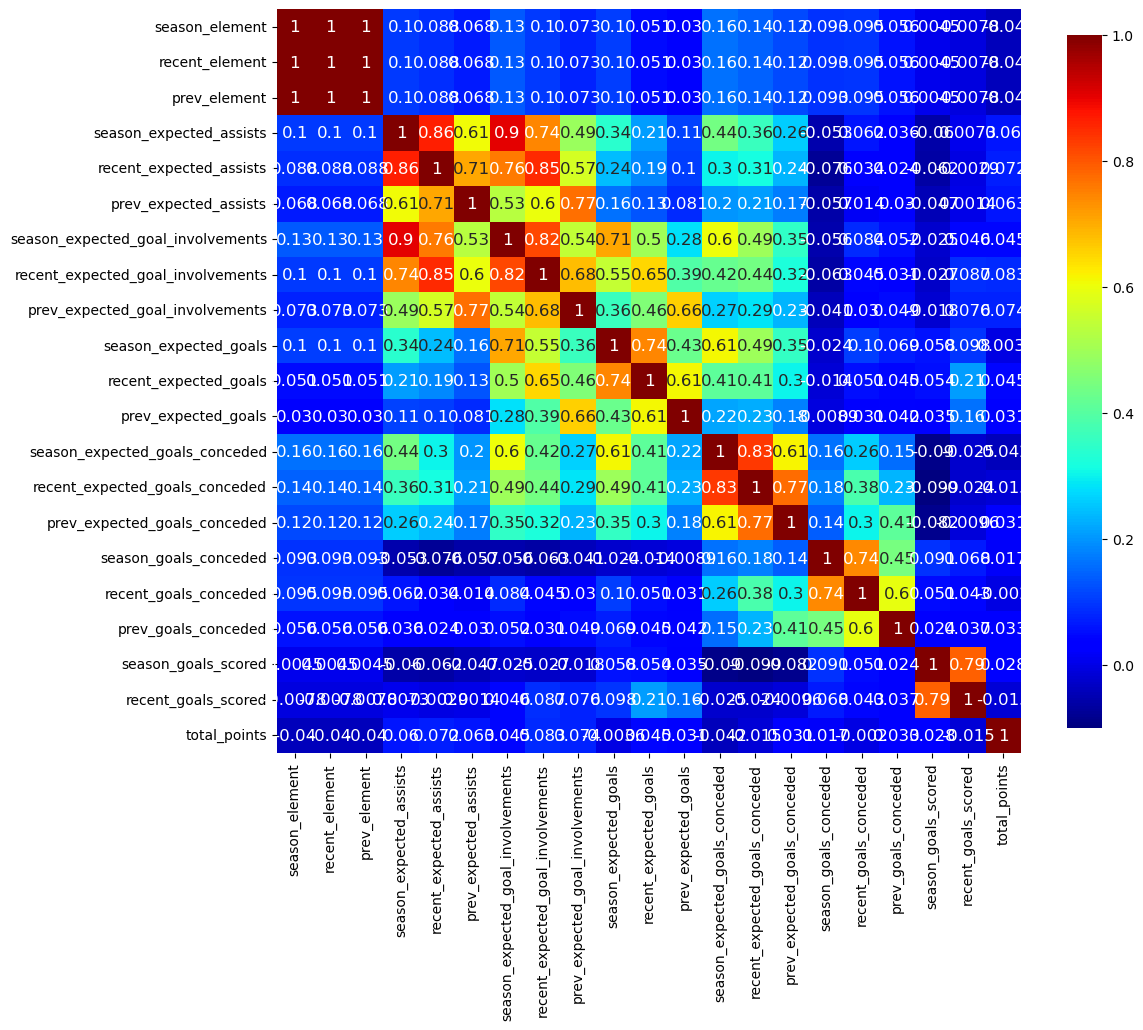

In [47]:
numeric_fpl_23 = fpl_23.select_dtypes(include=['number'])
coln=numeric_fpl_23.columns.get_loc('total_points')
cols_to_select = list(range(20,40)) + [coln] 
f15=numeric_fpl_23.iloc[:,cols_to_select]
from matplotlib import cm as cm

plt.figure()

corr = f15.corr(method='pearson')
cmap = plt.colormaps['jet']
#cmap = cm.get_cmap('jet', 30)
_, ax = plt.subplots( figsize = ( 12 , 10 ) )
sns.heatmap(corr, cmap = cmap,  square=True, cbar_kws={ 'shrink' : .9 }, ax=ax, annot = True, annot_kws = { 'fontsize' : 12 }, xticklabels=corr.columns, yticklabels=corr.columns)
plt.show()

#### Feature selection - Classifcation

best combination (ACC: 0.352): (0, 33, 35, 36, 48, 52, 54, 59, 60, 63, 70, 72, 73, 75)

all subsets:
 {1: {'feature_idx': (33,), 'cv_scores': array([0.26200836, 0.26120546, 0.24464284, 0.20951782, 0.2263996 ]), 'avg_score': 0.2407548168867793, 'feature_names': ('prev_expected_goals_conceded',)}, 2: {'feature_idx': (33, 36), 'cv_scores': array([0.31902163, 0.33183446, 0.23193984, 0.25044594, 0.27924749]), 'avg_score': 0.28249787158898537, 'feature_names': ('prev_expected_goals_conceded', 'prev_goals_conceded')}, 3: {'feature_idx': (33, 36, 52), 'cv_scores': array([0.3415483 , 0.34021989, 0.28256506, 0.25710344, 0.28287011]), 'avg_score': 0.3008613593431625, 'feature_names': ('prev_expected_goals_conceded', 'prev_goals_conceded', 'season_penalties_missed')}, 4: {'feature_idx': (33, 36, 52, 59), 'cv_scores': array([0.33395742, 0.33074311, 0.26245477, 0.26080231, 0.29653821]), 'avg_score': 0.2968991630939486, 'feature_names': ('prev_expected_goals_conceded', 'prev_goals_conceded', 'season_

(<Figure size 1000x1000 with 1 Axes>,
 <Axes: xlabel='Number of Features', ylabel='Performance'>)

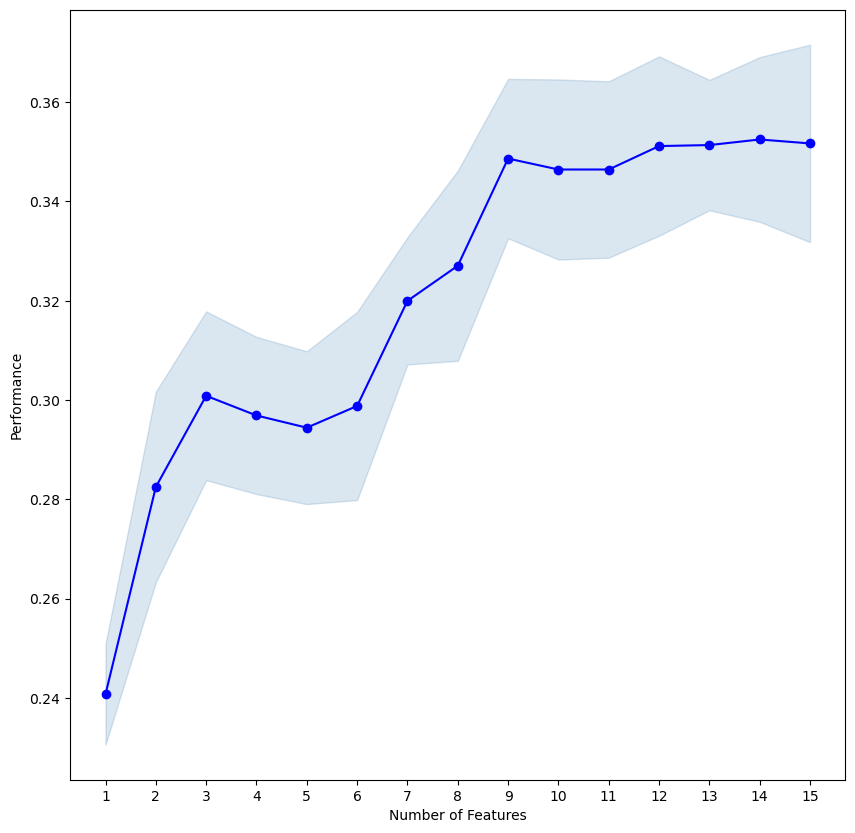

In [48]:
f1 = make_scorer(f1_score, average='macro')

rfc = RandomForestClassifier()
sfs_range = SFS(estimator=rfc, 
           k_features=(2, 15),
           forward=True, 
           floating=False, 
           scoring=f1,
           cv=5)

sfs_range = sfs_range.fit(x, ycl)

print('best combination (ACC: %.3f): %s\n' % (sfs_range.k_score_, sfs_range.k_feature_idx_))
print('all subsets:\n', sfs_range.subsets_)
plt.rcParams["figure.figsize"] = (10,10)
plot_sfs(sfs_range.get_metric_dict(), kind='std_err')

In [49]:
best_feature_names1 = x.columns[list(sfs_range.k_feature_idx_)]
best_feature_names1

Index(['round', 'prev_expected_goals_conceded', 'recent_goals_conceded',
       'prev_goals_conceded', 'prev_minutes', 'season_penalties_missed',
       'prev_penalties_missed', 'recent_red_cards', 'prev_red_cards',
       'prev_saves', 'season_team_a_score', 'prev_team_a_score',
       'season_team_h_score', 'prev_team_h_score'],
      dtype='object')

best combination (ACC: 0.306): (15, 33, 36, 49, 50, 55, 56, 57, 59, 62, 63, 69, 73)

all subsets:
 {1: {'feature_idx': (33,), 'cv_scores': array([0.24206506, 0.26999498, 0.20929209, 0.20215   , 0.2388325 ]), 'avg_score': 0.23246692506163885, 'feature_names': ('prev_expected_goals_conceded',)}, 2: {'feature_idx': (33, 36), 'cv_scores': array([0.28691194, 0.33396472, 0.22975939, 0.24893722, 0.29518613]), 'avg_score': 0.27895188020786754, 'feature_names': ('prev_expected_goals_conceded', 'prev_goals_conceded')}, 3: {'feature_idx': (33, 36, 73), 'cv_scores': array([0.30508244, 0.34351799, 0.24567858, 0.24519742, 0.31966035]), 'avg_score': 0.29182735337931365, 'feature_names': ('prev_expected_goals_conceded', 'prev_goals_conceded', 'season_team_h_score')}, 4: {'feature_idx': (15, 33, 36, 73), 'cv_scores': array([0.32253837, 0.35081975, 0.27240341, 0.25554525, 0.3166871 ]), 'avg_score': 0.3035987772927954, 'feature_names': ('prev_clean_sheets', 'prev_expected_goals_conceded', 'prev_goals_con

(<Figure size 1000x1000 with 1 Axes>,
 <Axes: xlabel='Number of Features', ylabel='Performance'>)

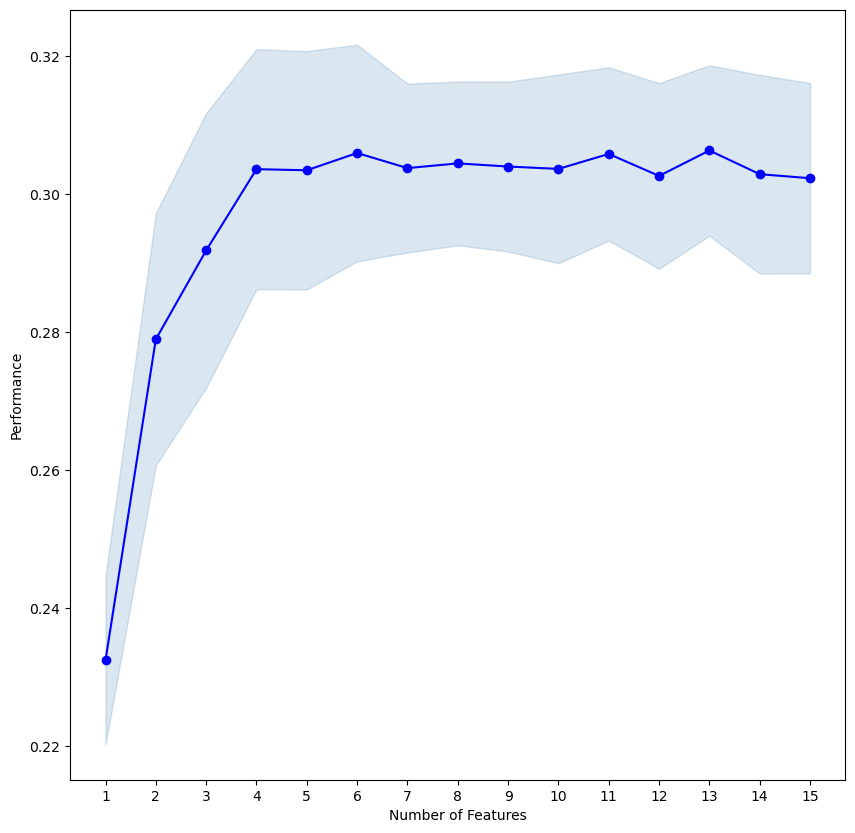

In [50]:
f1 = make_scorer(f1_score, average='macro')

dtc = DecisionTreeClassifier()
sfs_range = SFS(estimator=dtc, 
           k_features=(2, 15),
           forward=True, 
           floating=False, 
           scoring=f1,
           cv=5)

sfs_range = sfs_range.fit(x, ycl)

print('best combination (ACC: %.3f): %s\n' % (sfs_range.k_score_, sfs_range.k_feature_idx_))
print('all subsets:\n', sfs_range.subsets_)
plt.rcParams["figure.figsize"] = (10,10)
plot_sfs(sfs_range.get_metric_dict(), kind='std_err')

In [51]:
xnames2 = x.columns[list(sfs_range.k_feature_idx_)]
xnames2

Index(['prev_clean_sheets', 'prev_expected_goals_conceded',
       'prev_goals_conceded', 'season_own_goals', 'recent_own_goals',
       'season_penalties_saved', 'recent_penalties_saved',
       'prev_penalties_saved', 'recent_red_cards', 'recent_saves',
       'prev_saves', 'prev_starts', 'season_team_h_score'],
      dtype='object')

In [53]:
X_sfs = x.loc[:,['round', 'prev_expected_goals_conceded', 'recent_goals_conceded',
       'prev_goals_conceded', 'prev_minutes', 'season_penalties_missed',
       'prev_penalties_missed', 'recent_red_cards', 'prev_red_cards',
       'prev_saves', 'season_team_a_score', 'prev_team_a_score',
       'season_team_h_score', 'prev_team_h_score']]

In [55]:
#Dividing data into test & train splitting 80% data for training anf 20% for test
X_train, X_test, y_train, y_test = train_test_split(X_sfs, ycl, test_size=0.20)
print('There are {} samples in the training set and {} samples in the test set'.format(X_train.shape[0], X_test.shape[0]))

There are 1276 samples in the training set and 319 samples in the test set


In [56]:
plt.rcParams["figure.figsize"] = (5,5)
 
# Making a list of all classifiers
classifier_model = [GaussianNB(), SVC(), DecisionTreeClassifier(), RandomForestClassifier(), SGDClassifier(), AdaBoostClassifier()]
 
# Creating empty list to store the performance details
classifier_model_list= []
classifier_accuracy_test = []
classifier_accuracy_train = []
f1score = []
precisionscore = []
recallscore = []
#avg_pre_rec_score = []
cv_score = []
 
 
for classifier_list in classifier_model:
    classifier = classifier_list
    # Fitting the training set into classification model
    classifier.fit(X_train,y_train)
    # Predicting the output on test dataset
    y_pred_test = classifier.predict(X_test)    
    score_test = accuracy_score(y_test, y_pred_test)
    # Predicting the output on training datset
    y_pred_train = classifier.predict(X_train) 
    score_train = accuracy_score(y_train, y_pred_train)
    # Cross Validation Score on training test
    scores = cross_val_score(classifier, X_train,y_train, cv=10)
    cv_score.append(scores.mean())
    #Keeping the model and accuracy score into a list
    classifier_model_list.append(classifier_list.__class__.__name__)
    classifier_accuracy_test.append(round(score_test,4))
    classifier_accuracy_train.append(round(score_train,4))
    #Precision, Recall and F1 score
    f1score.append(f1_score(y_test, y_pred_test, average='macro'))
    precisionscore.append(precision_score(y_test, y_pred_test, average='macro', zero_division=0))
    recallscore.append(recall_score(y_test, y_pred_test, average='macro'))

In [57]:
#Creating pandas dataframe with Model and corresponding accuracy
#accuracy_df = pd.DataFrame({'Model':classifier_model_list , 'Test Accuracy':classifier_accuracy_test, 'Train Accuracy' :classifier_accuracy_test , 'Precision':precisionscore, 'Recall':recallscore ,'F1 Score':f1score},index=None)
accuracy_df = pd.DataFrame({'Model':classifier_model_list , 'Cross Val Score':cv_score, 'Test Accuracy' :classifier_accuracy_test , 'Precision':precisionscore, 'Recall':recallscore, 'F1 Score':f1score})

# Calculating Average Accuracy = (Test + Train)/2
accuracy_df['Average_Accuracy'] =  (accuracy_df['Cross Val Score'] + accuracy_df['Test Accuracy'] )/ 2

#Arranging the Columns
print("\n*------------------------------    CLASSIFICATION MODEL PERFORMANCE EVALUATION      ---------------------*\n")
accuracy_df = accuracy_df[['Model','Cross Val Score', 'Test Accuracy', 'Average_Accuracy','Precision', 'Recall', 'F1 Score']]  # This will arrange the columns in the order we want

#Sorting the Columns based on Average Accuracy
accuracy_df.sort_values('Average_Accuracy', axis=0, ascending=False, inplace=True) # Sorting the data with highest accuracy in the top
accuracy_df
#accuracy_df.transpose()


*------------------------------    CLASSIFICATION MODEL PERFORMANCE EVALUATION      ---------------------*



,Model,Cross Val Score,Test Accuracy,Average_Accuracy,Precision,Recall,F1 Score
3,RandomForestClassifier,0.409092,0.4451,0.427096,0.397080,0.367100,0.367539
2,DecisionTreeClassifier,0.356490,0.3699,0.363195,0.328605,0.317612,0.316383
1,SVC,0.307966,0.2790,0.293483,0.113562,0.198642,0.128129
5,AdaBoostClassifier,0.278193,0.2602,0.269196,0.183934,0.196574,0.184536
4,SGDClassifier,0.235132,0.2476,0.241366,0.150983,0.176021,0.144885
0,GaussianNB,0.148917,0.1473,0.148109,0.205983,0.204396,0.093835
